In [1]:
## Rete neurale con normalizzazione della loss
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from abc import ABC, abstractmethod

class FBSNN(ABC): # Forward-Backward Stochastic Neural Network
    def __init__(self, Xi, T,
                       M, N, D, alpha,
                       layers):

        self.Xi = Xi # initial point
        self.T = T # terminal time

        self.M = M # number of trajectories
        self.N = N # number of time snapshots
        self.D = D # number of dimensions

        # layers
        self.layers = layers # (D+1) --> 1

        # initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # tf placeholders and graph (training)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.alpha = alpha
        self.t_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, 1]) # M x (N+1) x 1
        self.W_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, self.D]) # M x (N+1) x D
        self.Xi_tf = tf.placeholder(tf.float32, shape=[1, D]) # 1 x D

        # ----- LOSS -----
        self.loss, self.X_pred, self.Y_pred, self.Y0_pred, self.Z_pred = \
            self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)

        # ----- PRETRAINING LOSS -----
        self.preloss, _, _, _, _ = \
            self.preloss_function(self.t_tf, self.W_tf, self.Xi_tf)

        # optimizers (same optimizer, two different train ops)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)

        self.train_op = self.optimizer.minimize(self.loss)
        self.pretrain_op = self.optimizer.minimize(self.preloss)

        # initialize session and variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            K = tf.add(tf.matmul(H, W), b)
            H1 = tf.keras.activations.relu(K)
            H2 = tf.sin(K)
            H = tf.add(H1, H2)
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t, X): # M x 1, M x D

        u = self.neural_net(tf.concat([t,X], 1), self.weights, self.biases) # M x 1
        Du = tf.gradients(u, X)[0] # M x D

        return u, Du

    def Dg_tf(self, X): # M x D
        return tf.gradients(self.g_tf(X), X)[0] # M x D

    def loss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Z0 = self.net_u(t0,X0) # M x 1, M x D
        #Z0 = tf.squeeze(tf.matmul(tf.expand_dims(Z0_,axis=1), self.sigma_tf(t0,X0,Y0)))
        
        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        dt = self.T/self.N
        
        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
            Y1, Z1 = self.net_u(t1,X1)
            #Z1 = tf.squeeze(tf.matmul(tf.expand_dims(Z1_,axis=1), self.sigma_tf(t1,X1,Y1)))

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))*tf.exp(-self.alpha * dt*n / self.T)

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)
        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        loss += tf.reduce_sum(tf.square(Z1 - self.Dg_tf(X1)))

        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)
        Z = tf.stack(Z_list,axis=1)

        return loss/self.N, X, Y, Y[0,0,0], Z

    def preloss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
        """
        Before the Deep FBSDE algorithm finds a decent approximation to the problem via least squares
        and uses that to calculate the loss wrt the net, this way there is an initial good guess for the net
        and later that good guess will get improved via the train method

        This method supposes that the forward dynamics do not depend upon Y or Z, if they do unintended behaviour
        """
        loss = 0
        X_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Z0 = self.net_u(t0,X0) # M x 1, M x D
        #Y0,Z0 at the moment are garbage values, we keep them just for simplicity in the for loop
        X_list.append(X0)
        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1)), axis=[-1])
            X0 = X1
            t0 = t1
            W0 = W1
            X_list.append(X0)
        X = tf.stack(X_list,axis=1) # M x (N + 1) x D
        Y_list = [None] * (N+1)
        Z_list = [None] * (N)

        # ---- Terminal condition ----
        X_N = X[:, self.N, :]
        t_N = t[:,self.N,:]
        Y_hat = self.g_tf(X_N)   # M x 1
        Y_list[N] = Y_hat
        Z_hat = tf.zeros_like(X_N) # M x D
        
        Y_pred, Z_pred = self.net_u(t_N,X_N)
        loss += tf.reduce_sum(tf.square(Y_pred - Y_hat))
        loss += tf.reduce_sum(tf.square(Z_pred - self.Dg_tf(X_N)))
        
        for n in reversed(range(0,self.N)):
            X_n = X[:, n, :]          # M x D
            X_np1 = X[:, n+1, :]
            t_np1 = t[:, n+1, :]
            dW_n = W[:, n+1, :] - W[:, n, :]  # M x D
            dt = self.T / self.N
            phi_np1 = self.phi_tf(t_np1, X_np1, Y_list[n+1], Z_hat)
            Y_target = Y_list[n+1] - phi_np1 * dt  # M x 1
            basis = self.basis_functions_lin(X_n)  # M x K
            beta = tf.linalg.lstsq(basis, Y_target, fast=False)
            Y_hat = tf.matmul(basis, beta)
            Y_list[n] = Y_hat   #regression Y_n
            Z_target = Y_list[n+1] * dW_n / dt  # M x D
            beta_Z = tf.linalg.lstsq(basis, Z_target, fast=False)
            Z_hat = tf.matmul(basis, beta_Z)
            Z_list[n] = Z_hat   #regression Z_n

            Y_pred, Z_pred = self.net_u(t[:,n,:],X_n)
            loss += tf.reduce_sum(tf.square(Y_pred - Y_hat))*tf.exp(-self.alpha * dt*n / self.T) #3 means that at T e^-3\approx *0.05
            loss += tf.reduce_sum(tf.square(Z_pred - Z_hat))*tf.exp(-self.alpha * dt*n / self.T)

        Y = tf.stack(Y_list,axis=1)
        Z = tf.stack(Z_list,axis=1)

        return loss/self.N, X, Y, Y[0,0,0], Z

    def basis_functions_lin(self, X):

        # X: M x D
        ones = tf.ones([tf.shape(X)[0], 1])
        return tf.concat([ones, X], axis=1)  # Linear basis

        
    def basis_functions_quad(self, X):

        ones = tf.ones([self.M, 1], dtype=X.dtype)

        # Linear
        linear = X

        # Compute outer product for each sample
        X_exp = tf.expand_dims(X, 2)  # M x D x 1
        X_outer = tf.matmul(X_exp, X_exp, transpose_b=True)  # M x D x D

        # Extract upper triangular part (including diagonal)
        mask = tf.linalg.band_part(tf.ones([self.D, self.D]), 0, -1)  # upper triangle
        mask = tf.cast(mask, dtype=tf.bool)

        quadratic = tf.boolean_mask(X_outer, mask, axis=1)
        quadratic = tf.reshape(quadratic, [self.M, -1])

        basis = tf.concat([ones, linear, quadratic], axis=1)

        return basis

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D

        return t, W

    def train(self, N_Iter, learning_rate):

        start_time = time.time()
        for it in range(N_Iter):

            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D

            tf_dict = {self.Xi_tf: self.Xi, self.t_tf: t_batch, self.W_tf: W_batch, self.learning_rate: learning_rate}

            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate_value = self.sess.run([self.loss, self.Y0_pred, self.learning_rate], tf_dict)
                print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_value, elapsed, learning_rate_value))
                start_time = time.time()

    def pretrain(self, N_Iter, learning_rate):

        start_time = time.time()
        for it in range(N_Iter):

            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D

            tf_dict = {self.Xi_tf: self.Xi, self.t_tf: t_batch, self.W_tf: W_batch, self.learning_rate: learning_rate}

            self.sess.run(self.pretrain_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate_value = self.sess.run([self.preloss, self.Y0_pred, self.learning_rate], tf_dict)
                print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_value, elapsed, learning_rate_value))
                start_time = time.time()

        
    def predict(self, Xi_star, t_star, W_star):

        tf_dict = {self.Xi_tf: Xi_star, self.t_tf: t_star, self.W_tf: W_star}

        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)

        return X_star, Y_star, Z_star

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        pass # M x1

    @abstractmethod
    def g_tf(self, X): # M x D
        pass # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M,D])) # M x D x D
    ###########################################################################


2026-02-12 16:46:53.195964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class Toy1(FBSNN):
    def __init__(self, Xi, T, M, N, D, alpha, layers, parameters):
        # Assicurati che nel main il dizionario si chiami 'parameters' o cambia qui in 'params'
        self.mu1 = parameters['mu1']
        self.mu2 = parameters['mu2']
        self.mu3 = parameters['mu3']
        self.c1 = parameters['c1']
        self.c2 = parameters['c2']
        self.c3 = parameters['c3']
        self.s1 = parameters['s1']
        self.s2 = parameters['s2']
        self.s3 = parameters['s3']
        super().__init__(Xi, T, M, N, D, alpha, layers)

    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)

        mu1 = tf.cast(self.mu1, tf.float32)
        mu2 = tf.cast(self.mu2, tf.float32)
        mu3 = tf.cast(self.mu3, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        c2 = tf.cast(self.c2, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)

        dS = mu1 * (c1 - S)
        dH = mu2 * (c2 - H)
        dV = mu3 * (c3 - V)
        dX = V

        return tf.concat([dS, dH, dV, dX], axis=1)

    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        return X_state**2 + S * (V+H)

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)

        mu1 = tf.cast(self.mu1, tf.float32)
        mu2 = tf.cast(self.mu2, tf.float32)
        mu3 = tf.cast(self.mu3, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        c2 = tf.cast(self.c2, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)

        return (2*X_state*V + mu1 * (c1 - S) * (V + H) + mu2*(c2-H)*S +mu3 * (c3-V) * S)

    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        s2 = tf.cast(self.s2, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)

        zeros = tf.zeros_like(S)
        ones = tf.ones_like(S)

        # Qui sigma1 è costante (moltiplica ones) perchè S è Ornstein-Uhlenbeck. Corretto.
        r1 = tf.concat([s1 * ones, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * ones, zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * ones, zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        return tf.stack([r1, r2, r3, r4], axis=1)

    def u_exact(self,t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]

        return X**2 + S * (V + H)

    def grad_u_exact(self,t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]
        r1 = params['s1'] * (V + H)
        r2 = params['s2'] * S
        r3 = params['s3'] * S
        r4 = np.zeros_like(S)

        return np.stack([r1, r2, r3, r4], axis=1)

In [3]:
import matplotlib.pyplot as plt
import os

def plot_all(model,Xi,savedir,savename):
    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)
    Xi_reshaped = X_pred.reshape(-1, model.D)
    t_reshaped = t_test.reshape(-1, 1)

    # Calcolo soluzione esatta sui punti predetti
    Y_exact = model.u_exact(t_reshaped, Xi_reshaped).reshape(model.M, model.N+1, 1)
    Z_exact = model.grad_u_exact(t_reshaped, Xi_reshaped).reshape(model.M, model.N+1, model.D, 1)

    exact_Y0 = model.u_exact(np.array([[0.0]]), Xi)[0,0]
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
        # Plot di altre traiettorie per vedere la varianza
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Y")
    plt.xlabel("Tempo t")
    plt.ylabel("Y_t")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{savedir}/Y_{savename}.png')
    
    #print(Z_pred.shape)
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], np.mean(np.abs((Y_pred[:,:,0]-Y_exact[:,:,0])),axis=0), 'b', label='Mean Error of Y')
    plt.title("u abs error")
    plt.xlabel("Tempo t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{savedir}/Y_absErr_{savename}.png')
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], np.mean(np.abs((Y_pred[:,:,0]-Y_exact[:,:,0])),axis=0)/np.mean(np.abs(Y_exact[:,:,0]),axis=0), 'b', label='Mean Error of Y')
    plt.title("u rel error")
    plt.xlabel("Tempo t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{savedir}/Y_relErr_{savename}.png')
    
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], np.mean(np.abs((Z_pred[:,:,0]-Z_exact[:,:,0,0])),axis=0), 'b', label='Mean Error of Z_S')
    plt.plot(t_test[0,:,0], np.mean(np.abs((Z_pred[:,:,1]-Z_exact[:,:,1,0])),axis=0), 'g', label='Mean Error of Z_H')
    plt.plot(t_test[0,:,0], np.mean(np.abs((Z_pred[:,:,2]-Z_exact[:,:,2,0])),axis=0), 'r', label='Mean Error of Z_V')
    plt.title("Grad_u abs error")
    plt.xlabel("Tempo t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{savedir}/Z_absErr_{savename}.png')
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], np.mean(np.abs((Z_pred[:,:,0]-Z_exact[:,:,0,0])),axis=0)/np.mean(np.abs(Z_exact[:,:,0,0]),axis=0), 'b', label='Mean Error of Z_S')
    plt.plot(t_test[0,:,0], np.mean(np.abs((Z_pred[:,:,1]-Z_exact[:,:,1,0])),axis=0)/np.mean(np.abs(Z_exact[:,:,0,0]),axis=0), 'g', label='Mean Error of Z_H')
    plt.plot(t_test[0,:,0], np.mean(np.abs((Z_pred[:,:,2]-Z_exact[:,:,2,0])),axis=0)/np.mean(np.abs(Z_exact[:,:,0,0]),axis=0), 'r', label='Mean Error of Z_V')
    plt.title("Grad_u rel error")
    plt.xlabel("Tempo t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{savedir}/Z_relErr_{savename}.png')

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1770914816.567838    7410 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13136 MB memory:  -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0


In [5]:
M = 512
N = 100
D = 4
T = 48.0
alpha = 4

params = {
        'mu1': np.float32(1.0),
        'mu2': np.float32(1.0),
        'mu3': np.float32(1.0),
        'c1': np.float32(1.0),
        'c2': np.float32(1.0),
        'c3': np.float32(1.0),
        's1': np.float32(1),
        's2': np.float32(1),
        's3': np.float32(1),
    }

Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)

layers = [D+1] + 4*[256] + [1]

model = Toy1(Xi, T, M, N, D, alpha, layers, params)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0



I0000 00:00:1770914816.721630    7410 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13136 MB memory:  -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0
I0000 00:00:1770914848.452829    7410 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2026-02-12 16:47:29.152212: I tensorflow/core/common_runtime/placer.cc:162] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-12 16:47:29.152233: I tensorflow/core/common_runtime/placer.cc:162] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-12 16:47:29.152238: I tensorflow/core/common_runtime/placer.cc:162] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-12 16:47:29.152242: I tensorflow/core/common_runtime/placer.cc:162] Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-12 16:47:29.152249: I tensorflow/core/common_runti

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Var

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



It: 0, Loss: 6.167e+07, Y0: 0.437, Time: 13.66, Learning Rate: 1.000e-03
It: 10, Loss: 5.372e+07, Y0: 12.364, Time: 2.22, Learning Rate: 1.000e-03
It: 20, Loss: 2.545e+07, Y0: 47.157, Time: 2.11, Learning Rate: 1.000e-03
It: 30, Loss: 1.000e+07, Y0: 11.194, Time: 2.15, Learning Rate: 1.000e-03
It: 40, Loss: 4.225e+06, Y0: -6.636, Time: 2.17, Learning Rate: 1.000e-03
It: 50, Loss: 3.116e+06, Y0: 6.021, Time: 2.18, Learning Rate: 1.000e-03
It: 60, Loss: 2.952e+06, Y0: 83.756, Time: 2.14, Learning Rate: 1.000e-03
It: 70, Loss: 2.708e+06, Y0: 33.170, Time: 2.18, Learning Rate: 1.000e-03
It: 80, Loss: 2.874e+06, Y0: 28.241, Time: 2.20, Learning Rate: 1.000e-03
It: 90, Loss: 2.627e+06, Y0: 20.658, Time: 2.21, Learning Rate: 1.000e-03
It: 100, Loss: 2.449e+06, Y0: 13.543, Time: 2.23, Learning Rate: 1.000e-03
It: 110, Loss: 2.714e+06, Y0: 10.000, Time: 2.22, Learning Rate: 1.000e-03
It: 120, Loss: 2.699e+06, Y0: 9.108, Time: 2.20, Learning Rate: 1.000e-03
It: 130, Loss: 2.488e+06, Y0: 5.849, T

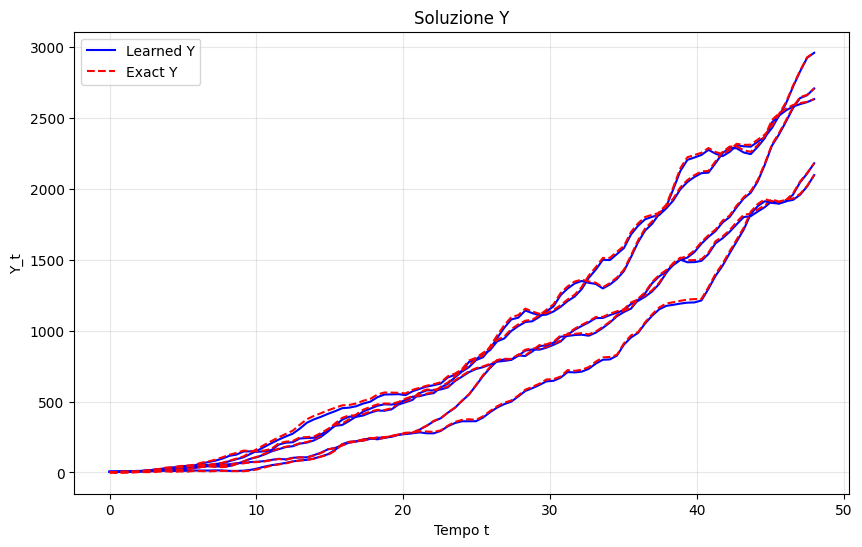

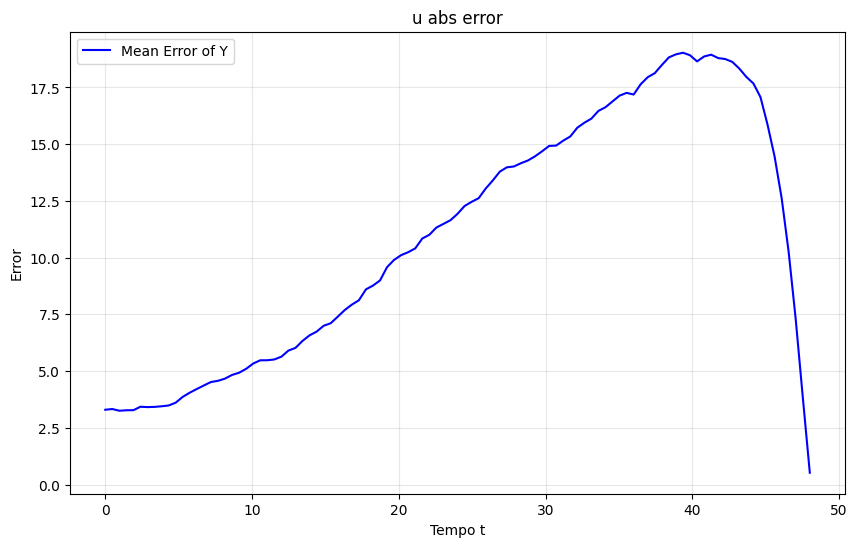

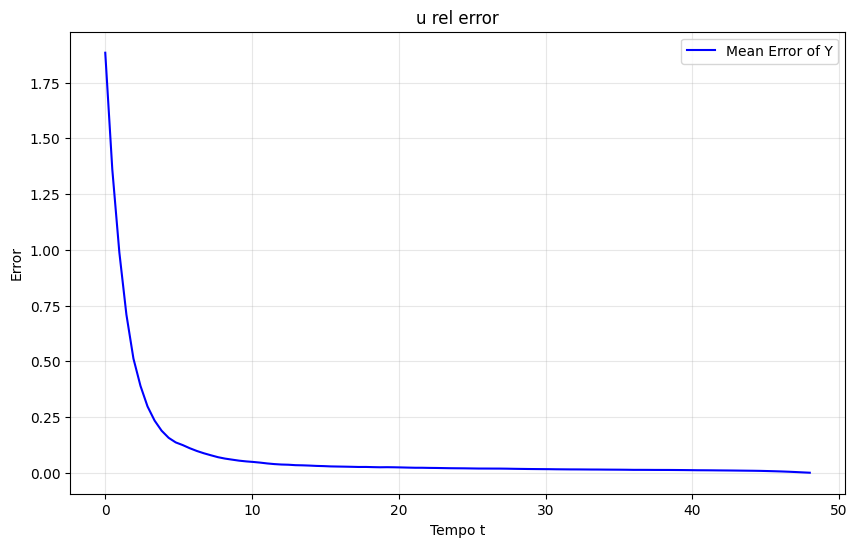

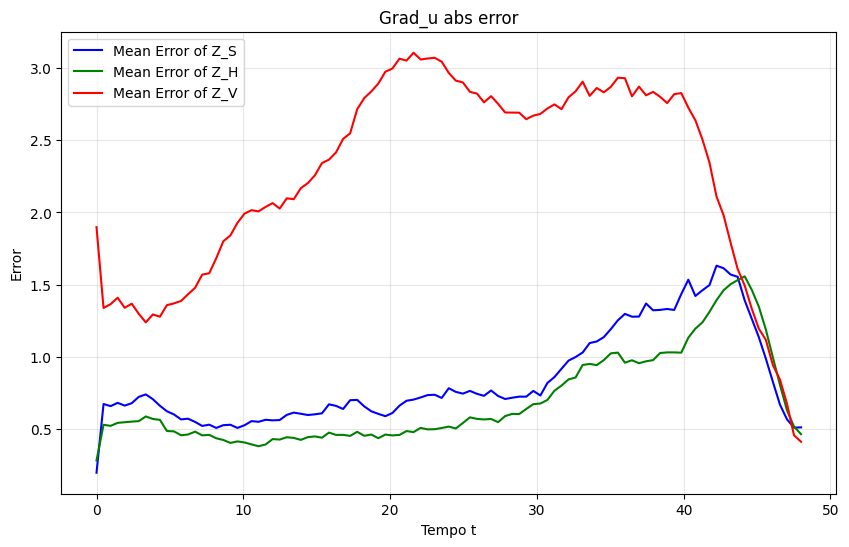

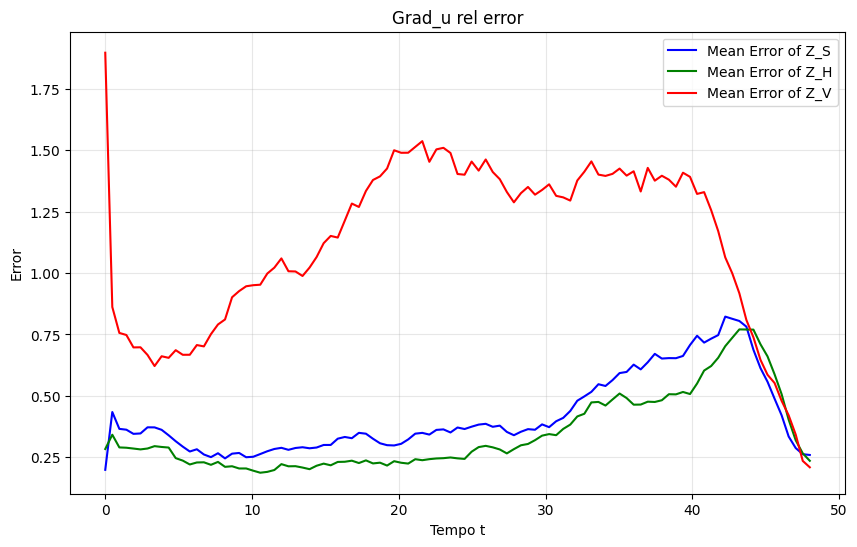

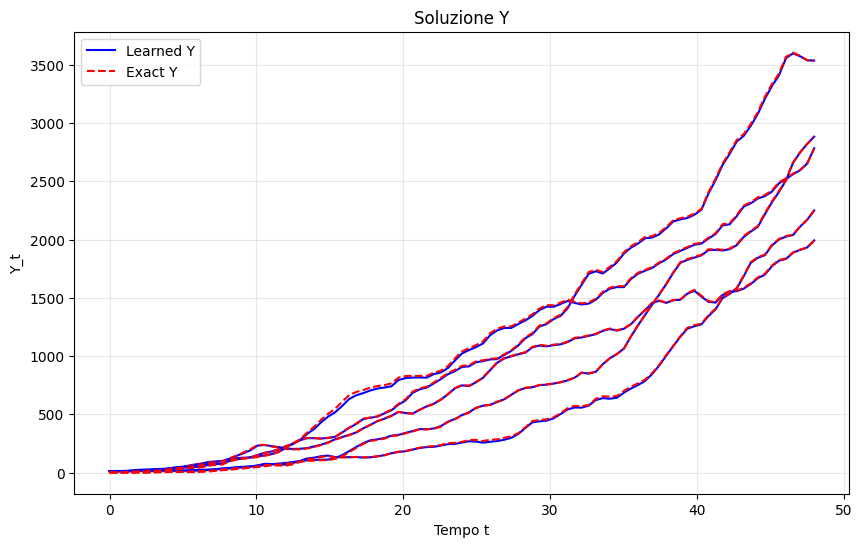

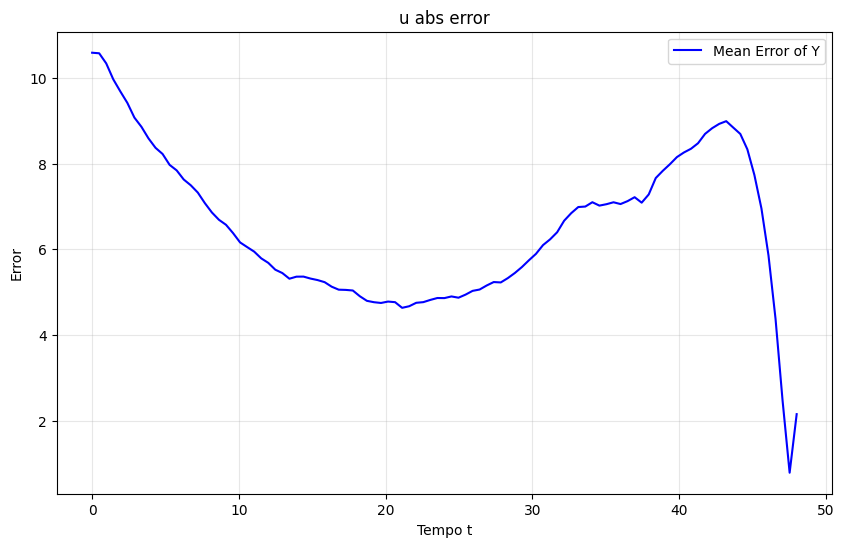

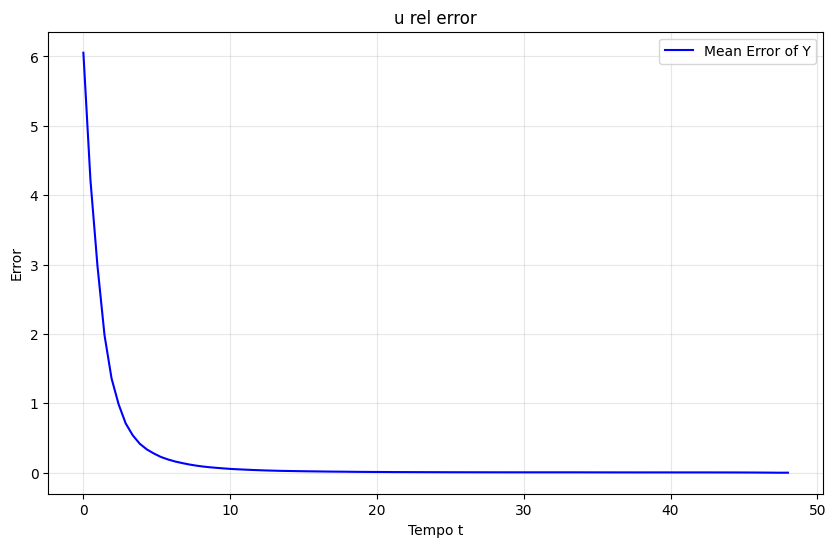

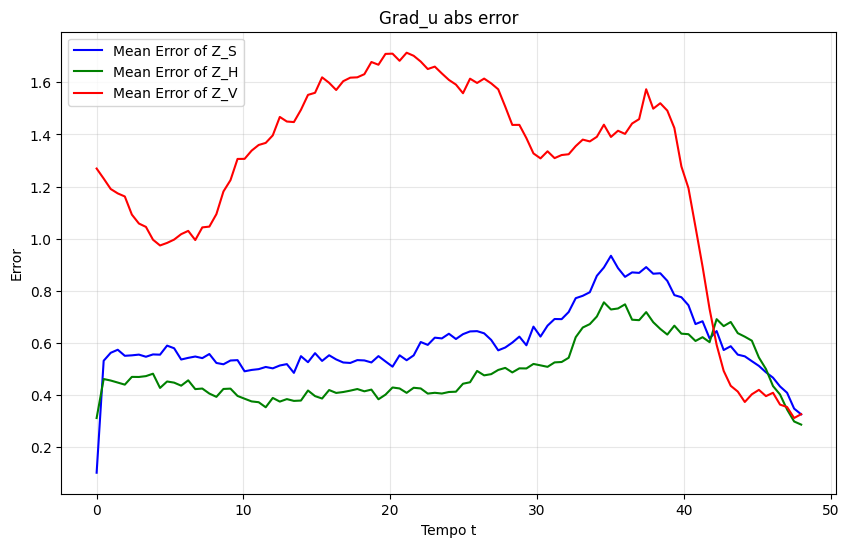

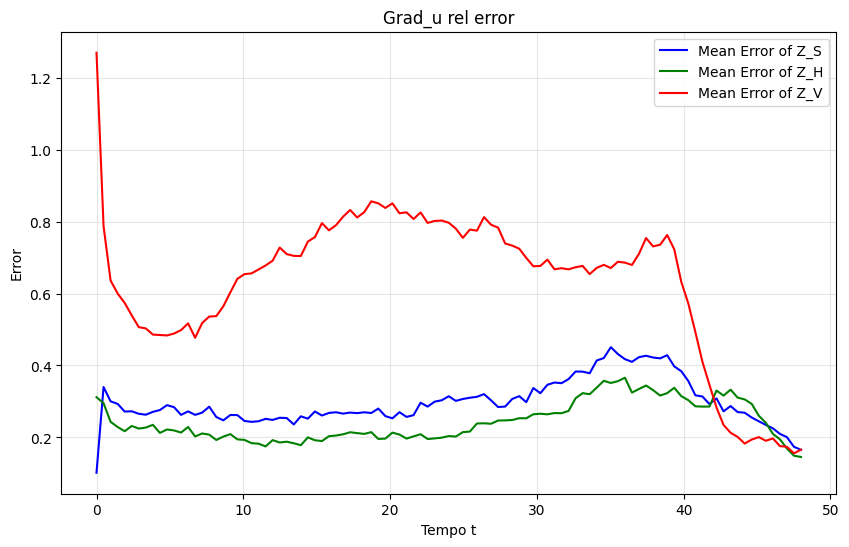

In [6]:
model.pretrain(N_Iter = 1000, learning_rate = 1e-3)
model.train(N_Iter = 2000, learning_rate = 1e-3)
dire = 'plots/Toy1/1000+2000/'
os.makedirs(dire, exist_ok=True)
plot_all(model,Xi,dire,'T=48_alpha=4')

model.train(N_Iter = 2000, learning_rate = 1e-3)
dire = 'plots/Toy1/1000+4000/'
os.makedirs(dire, exist_ok=True)
plot_all(model,Xi,dire,'T=48_alpha=4')